In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [13]:
# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (12, 8)

In [14]:
try:
    # Carregar dados
    X_scaled = np.load('../data/features/X_scaled_agregado.npy', allow_pickle=True)
    feature_names = np.load('../data/features/feature_names_agregado.npy', allow_pickle=True)
    player_names = np.load('../data/features/player_names.npy', allow_pickle=True)
    df_agregado = pd.read_csv('../data/processed_data/dados_processados_agregados.csv')
    
    print(f"✓ Dados carregados: {X_scaled.shape[0]} jogadores, {X_scaled.shape[1]} features")
except FileNotFoundError:
    print("ERRO: Arquivos .npy ou .csv não encontrados.")
    print("Por favor, execute o Notebook 1 (com a célula de salvar) primeiro.")
    raise

✓ Dados carregados: 474 jogadores, 30 features


# DB-SCAN
- Vamos fazer o mesmo processo pro k-means, iremos encontrar os parâmetros ideais: 'eps' (distãncia) e o 'min_samples'

In [15]:
def otimizar_dbscan(X_scaled):
    """
    Otimização mais agressiva do DBSCAN para dados dispersos
    """
    print("=" * 70)
    print("OTIMIZAÇÃO DBSCAN - ABORDAGEM ADAPTATIVA")
    print("=" * 70)
    
    # Testar com min_samples MENORES (dados dispersos precisam disso)
    min_samples_range = [2, 3, 4, 5, 7, 10]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    eps_sugeridos = []
    
    for idx, min_samp in enumerate(min_samples_range):
        neighbors = NearestNeighbors(n_neighbors=min_samp)
        neighbors_fit = neighbors.fit(X_scaled)
        distances, indices = neighbors_fit.kneighbors(X_scaled)
        
        k_distances = np.sort(distances[:, min_samp-1], axis=0)
        
        # Plotar
        axes[idx].plot(k_distances, linewidth=2, color='steelblue')
        axes[idx].set_title(f'min_samples={min_samp}', fontweight='bold', fontsize=11)
        axes[idx].set_xlabel('Pontos', fontsize=9)
        axes[idx].set_ylabel(f'Dist. {min_samp}º viz.', fontsize=9)
        axes[idx].grid(True, alpha=0.3)
        
        # Detecção do joelho com suavização
        k_distances_smooth = gaussian_filter1d(k_distances, sigma=len(k_distances)//50)
        first_derivative = np.gradient(k_distances_smooth)
        second_derivative = np.gradient(first_derivative)
        
        # Procurar joelho entre 20% e 80% dos dados
        start_idx = int(len(second_derivative) * 0.2)
        end_idx = int(len(second_derivative) * 0.8)
        knee_idx = start_idx + np.argmax(second_derivative[start_idx:end_idx])
        eps_sugerido = k_distances[knee_idx]
        
        # Também considerar percentis
        eps_p90 = np.percentile(k_distances, 90)
        eps_p75 = np.percentile(k_distances, 75)
        
        # Usar o menor dos três para ser menos restritivo
        eps_final = min(eps_sugerido, eps_p90)
        
        axes[idx].axhline(y=eps_final, color='red', linestyle='--', 
                         linewidth=2, label=f'eps={eps_final:.3f}')
        axes[idx].axhline(y=eps_p75, color='orange', linestyle=':', 
                         alpha=0.7, label=f'p75={eps_p75:.3f}')
        axes[idx].legend(fontsize=8)
        
        eps_sugeridos.append((min_samp, eps_final))
        print(f"min_samples={min_samp:2d} → eps sugerido = {eps_final:.3f}")
    
    plt.tight_layout()
    plt.savefig('../images/03_dbscan_knee_analysis_adaptive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return eps_sugeridos

In [16]:
def avaliar_clustering(X_scaled, labels):
    """
    Avalia qualidade do clustering com múltiplas métricas
    """
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_ratio = n_noise / len(labels)
    
    if n_clusters < 2 or noise_ratio >= 0.7:
        return None
    
    mask = labels != -1
    if mask.sum() < 10:
        return None
    
    try:
        sil = silhouette_score(X_scaled[mask], labels[mask])
        db = davies_bouldin_score(X_scaled[mask], labels[mask])
        ch = calinski_harabasz_score(X_scaled[mask], labels[mask])
        
        # Score combinado balanceado
        # Penaliza muito ruído, premia clusters bem separados
        score = (sil * 0.4) + (ch / 1000 * 0.3) - (db / 10 * 0.2) - (noise_ratio * 0.1)
        
        return {
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': noise_ratio,
            'silhouette': sil,
            'davies_bouldin': db,
            'calinski_harabasz': ch,
            'combined_score': score
        }
    except:
        return None

In [17]:
def grid_search_dbscan(X_scaled, eps_sugeridos):
    """
    Grid search mais amplo e robusto
    """
    print("\n" + "=" * 70)
    print("GRID SEARCH EXPANDIDO")
    print("=" * 70)
    
    results = []
    
    for min_samp, eps_base in eps_sugeridos:
        # Testar numa faixa maior: 50% a 150% do eps sugerido
        eps_range = np.linspace(eps_base * 0.5, eps_base * 1.5, 15)
        
        # Também testar variações no min_samples
        min_samp_variants = [max(2, min_samp-1), min_samp, min_samp+1]
        
        for eps in eps_range:
            for ms in min_samp_variants:
                db = DBSCAN(eps=eps, min_samples=ms)
                labels = db.fit_predict(X_scaled)
                
                metrics = avaliar_clustering(X_scaled, labels)
                
                if metrics:
                    metrics['eps'] = eps
                    metrics['min_samples'] = ms
                    results.append(metrics)
    
    if not results:
        print("⚠️ Nenhuma configuração válida! Tentando parâmetros mais relaxados...")
        
        # Fallback: testar parâmetros muito relaxados
        for eps in np.linspace(0.3, 2.0, 20):
            for ms in [2, 3, 4, 5]:
                db = DBSCAN(eps=eps, min_samples=ms)
                labels = db.fit_predict(X_scaled)
                metrics = avaliar_clustering(X_scaled, labels)
                
                if metrics:
                    metrics['eps'] = eps
                    metrics['min_samples'] = ms
                    results.append(metrics)
    
    if not results:
        return None
    
    results_sorted = sorted(results, key=lambda x: x['combined_score'], reverse=True)
    
    print(f"\n{'#':<4} {'Eps':<7} {'MinS':<5} {'Cls':<4} {'Noise':<7} {'Silh':<6} {'DB':<6} {'CH':<7} {'Score':<7}")
    print("-" * 70)
    
    for i, r in enumerate(results_sorted[:15], 1):
        print(f"{i:<4} {r['eps']:<7.3f} {r['min_samples']:<5} {r['n_clusters']:<4} "
              f"{r['noise_ratio']*100:>6.1f}% {r['silhouette']:<6.3f} "
              f"{r['davies_bouldin']:<6.3f} {r['calinski_harabasz']:<7.1f} {r['combined_score']:<7.4f}")
    
    return results_sorted

In [18]:
def testar_algoritmos_alternativos(X_scaled, X_pca, n_clusters=4):
    """
    Testa outros algoritmos de clustering além de DBSCAN e K-Means
    """
    print("\n" + "=" * 70)
    print("TESTANDO ALGORITMOS ALTERNATIVOS")
    print("=" * 70)
    
    algoritmos = {}
    
    # 1. Agglomerative Clustering (Hierárquico)
    print("\n[1] Agglomerative Clustering...")
    agg_ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agg_avg = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    
    labels_ward = agg_ward.fit_predict(X_scaled)
    labels_avg = agg_avg.fit_predict(X_scaled)
    
    sil_ward = silhouette_score(X_scaled, labels_ward)
    sil_avg = silhouette_score(X_scaled, labels_avg)
    
    algoritmos['Hierarchical (Ward)'] = {'labels': labels_ward, 'silhouette': sil_ward}
    algoritmos['Hierarchical (Average)'] = {'labels': labels_avg, 'silhouette': sil_avg}
    
    print(f"   Ward linkage - Silhouette: {sil_ward:.3f}")
    print(f"   Average linkage - Silhouette: {sil_avg:.3f}")
    
    # 2. Mean Shift
    print("\n[2] Mean Shift...")
    try:
        bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=500)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        labels_ms = ms.fit_predict(X_scaled)
        n_clusters_ms = len(set(labels_ms))
        
        if n_clusters_ms > 1:
            sil_ms = silhouette_score(X_scaled, labels_ms)
            algoritmos['Mean Shift'] = {'labels': labels_ms, 'silhouette': sil_ms}
            print(f"   Clusters encontrados: {n_clusters_ms}")
            print(f"   Silhouette: {sil_ms:.3f}")
        else:
            print("   ⚠️ Encontrou apenas 1 cluster")
    except Exception as e:
        print(f"   ⚠️ Erro no Mean Shift: {e}")
    
    # 3. Visualizar comparação
    n_algos = len(algoritmos)
    if n_algos > 0:
        fig, axes = plt.subplots(1, n_algos, figsize=(6*n_algos, 5))
        if n_algos == 1:
            axes = [axes]
        
        for idx, (nome, dados) in enumerate(algoritmos.items()):
            scatter = axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], 
                                       c=dados['labels'], cmap='viridis',
                                       alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
            axes[idx].set_title(f'{nome}\nSilhouette: {dados["silhouette"]:.3f}', 
                               fontweight='bold')
            axes[idx].set_xlabel('PC1')
            axes[idx].set_ylabel('PC2')
            plt.colorbar(scatter, ax=axes[idx])
        
        plt.tight_layout()
        plt.savefig('../images/03_algoritmos_alternativos.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return algoritmos


In [19]:
def visualizar_dbscan_final(X_scaled, X_pca, best_params, df_agregado):
    """
    Visualização completa do melhor DBSCAN
    """
    if best_params is None:
        print("\n❌ Não foi possível encontrar parâmetros válidos para DBSCAN")
        print("   Recomendação: Use Hierarchical Clustering ou K-Means para seus dados")
        return None
    
    print("\n" + "=" * 70)
    print("RESULTADO FINAL - DBSCAN OTIMIZADO")
    print("=" * 70)
    
    print(f"\n🏆 Melhores parâmetros DBSCAN:")
    print(f"   EPS: {best_params['eps']:.4f}")
    print(f"   MIN_SAMPLES: {best_params['min_samples']}")
    print(f"   Clusters: {best_params['n_clusters']}")
    print(f"   Ruído: {best_params['n_noise']} ({best_params['noise_ratio']*100:.1f}%)")
    print(f"   Silhouette: {best_params['silhouette']:.4f}")
    print(f"   Davies-Bouldin: {best_params['davies_bouldin']:.4f}")
    print(f"   Calinski-Harabasz: {best_params['calinski_harabasz']:.2f}")
    
    # Aplicar modelo final
    dbscan_final = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
    labels = dbscan_final.fit_predict(X_scaled)
    
    # Visualização tripla
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot 1: Todos os pontos
    scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                               cmap='tab10', alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
    axes[0].set_title(f'DBSCAN: Todos os Pontos\n{len(labels)} pontos', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Componente Principal 1')
    axes[0].set_ylabel('Componente Principal 2')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0])
    
    # Plot 2: Apenas clusters válidos
    mask = labels != -1
    scatter2 = axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], c=labels[mask], 
                               cmap='tab10', alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
    axes[1].set_title(f'Apenas Clusters Válidos\n{mask.sum()} pontos, {best_params["n_clusters"]} clusters', 
                     fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Componente Principal 1')
    axes[1].set_ylabel('Componente Principal 2')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1])
    
    # Plot 3: Destacar outliers
    colors = ['red' if l == -1 else 'steelblue' for l in labels]
    axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.5, s=40)
    axes[2].set_title(f'Outliers vs Clusters\nVermelho = Outliers ({best_params["n_noise"]})', 
                     fontweight='bold', fontsize=12)
    axes[2].set_xlabel('Componente Principal 1')
    axes[2].set_ylabel('Componente Principal 2')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../images/03_dbscan_resultado_final.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return labels


INICIANDO ANÁLISE COMPLETA DE CLUSTERING
OTIMIZAÇÃO DBSCAN - ABORDAGEM ADAPTATIVA
min_samples= 2 → eps sugerido = 2.420
min_samples= 3 → eps sugerido = 2.853
min_samples= 4 → eps sugerido = 3.214
min_samples= 5 → eps sugerido = 3.389
min_samples= 7 → eps sugerido = 2.847
min_samples=10 → eps sugerido = 3.694


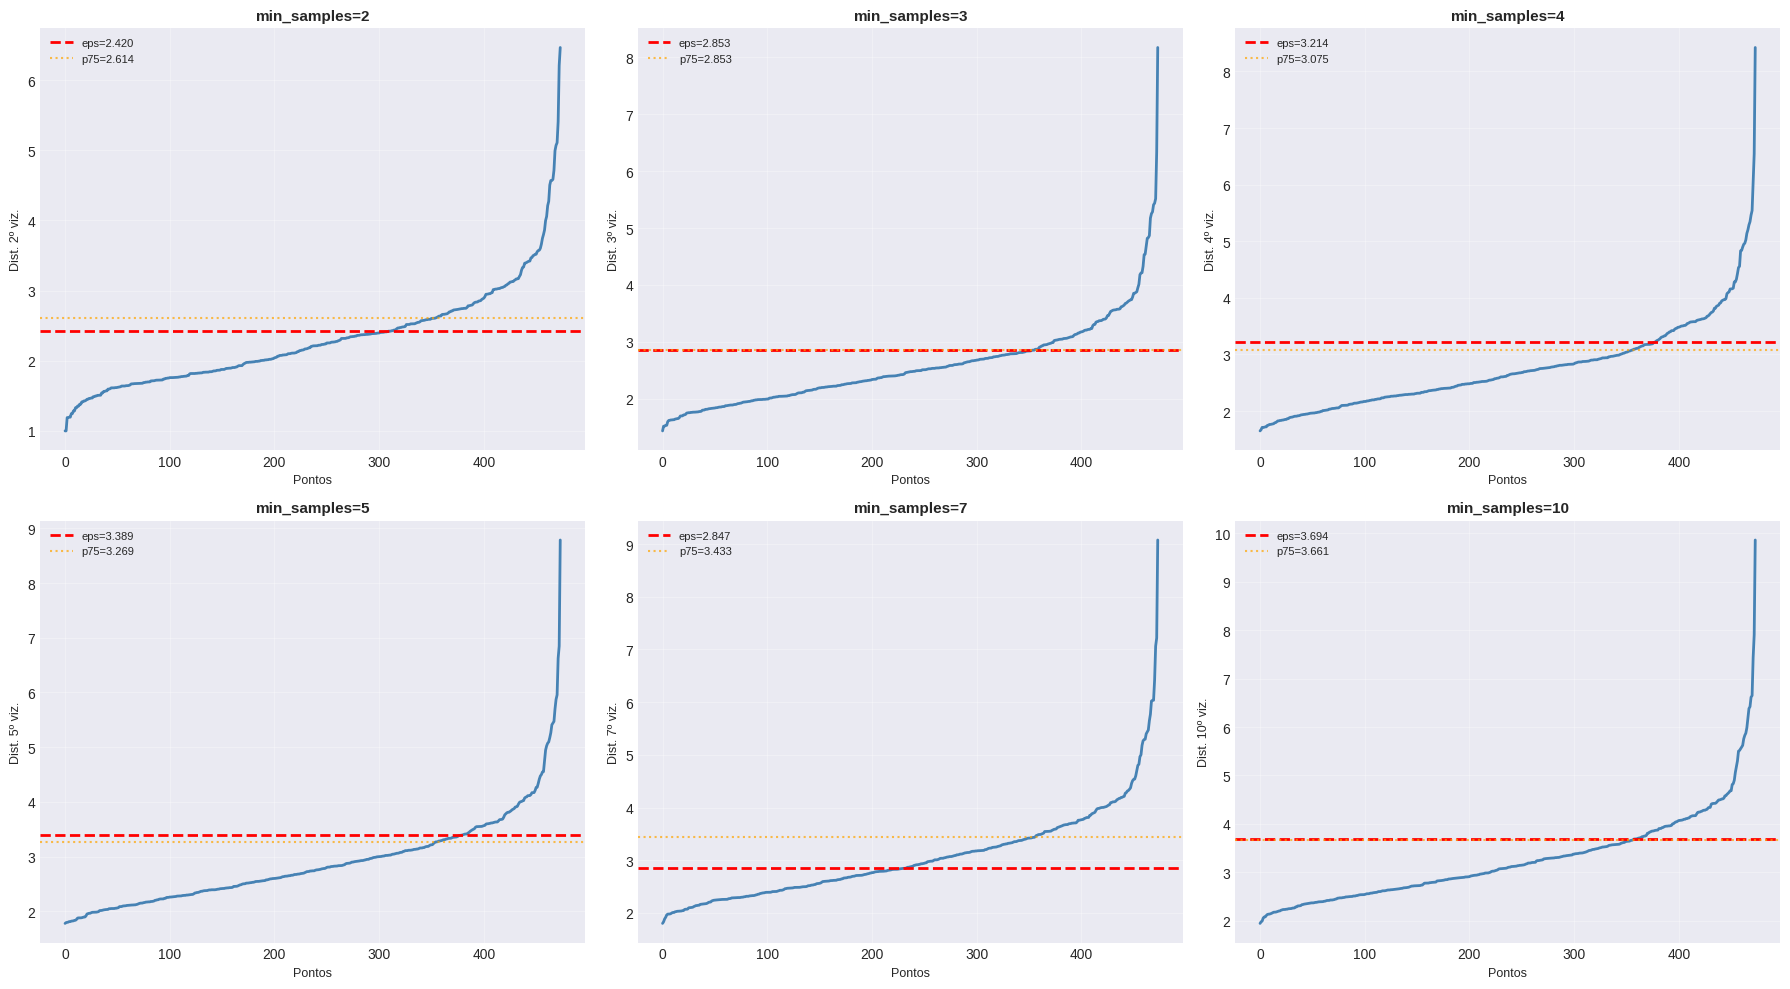


GRID SEARCH EXPANDIDO

#    Eps     MinS  Cls  Noise   Silh   DB     CH      Score  
----------------------------------------------------------------------
1    2.984   3     2      15.4% 0.372  0.602  12.7    0.1252 
2    3.056   3     2      13.5% 0.364  0.610  12.3    0.1236 
3    3.050   6     2      21.3% 0.358  0.784  20.5    0.1125 
4    3.147   6     2      17.1% 0.350  0.727  13.8    0.1124 
5    2.984   4     2      17.5% 0.345  0.667  10.5    0.1102 
6    3.253   8     2      15.8% 0.326  0.844  21.0    0.1039 
7    3.253   7     2      14.6% 0.321  0.861  23.3    0.1036 
8    3.214   3     4       9.5% 0.303  0.759  12.0    0.1002 
9    3.285   3     4       8.4% 0.294  0.761  11.7    0.0976 
10   3.260   3     4       8.4% 0.294  0.761  11.7    0.0976 
11   3.285   2     5       8.0% 0.289  0.748  10.6    0.0958 
12   3.285   2     5       8.0% 0.289  0.748  10.6    0.0958 
13   3.260   2     5       8.0% 0.289  0.748  10.6    0.0958 
14   3.458   2     2       6.1% 0.277

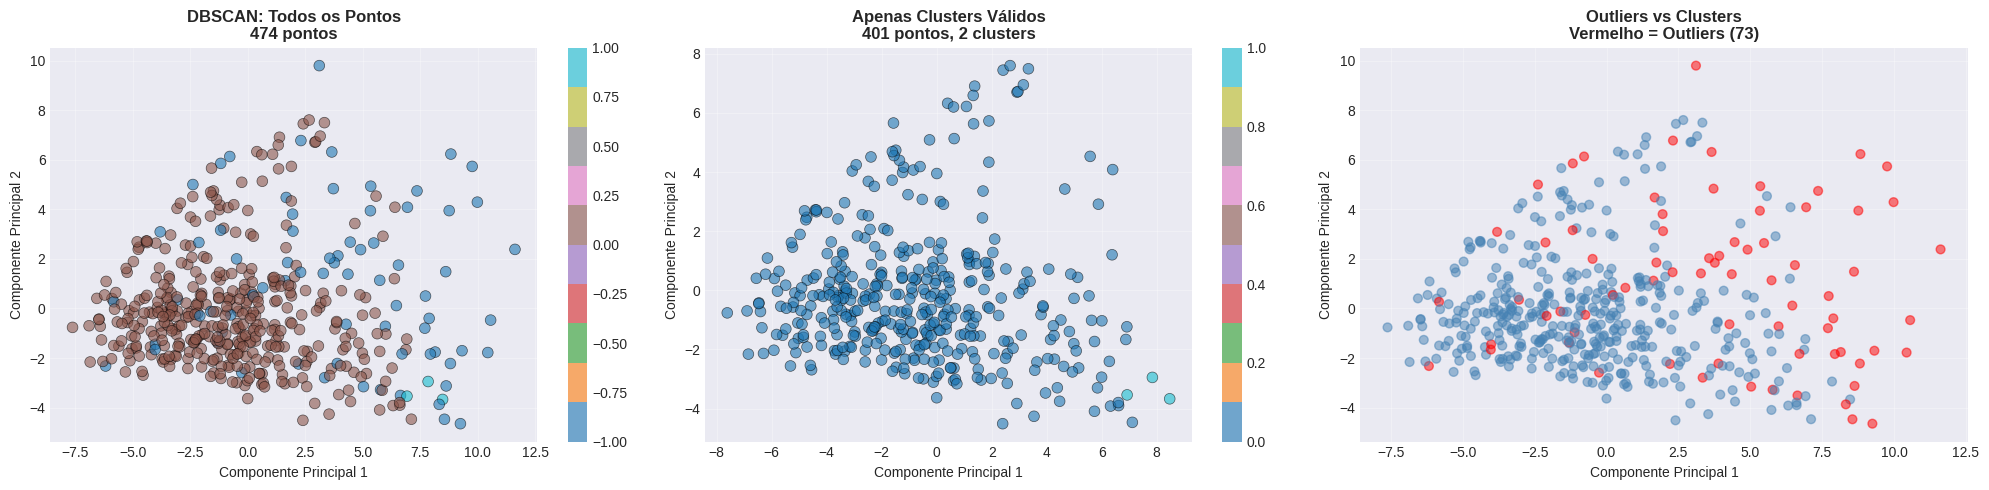


✓ DBSCAN aplicado com sucesso!

TESTANDO ALGORITMOS ALTERNATIVOS

[1] Agglomerative Clustering...
   Ward linkage - Silhouette: 0.187
   Average linkage - Silhouette: 0.235

[2] Mean Shift...
   ⚠️ Encontrou apenas 1 cluster


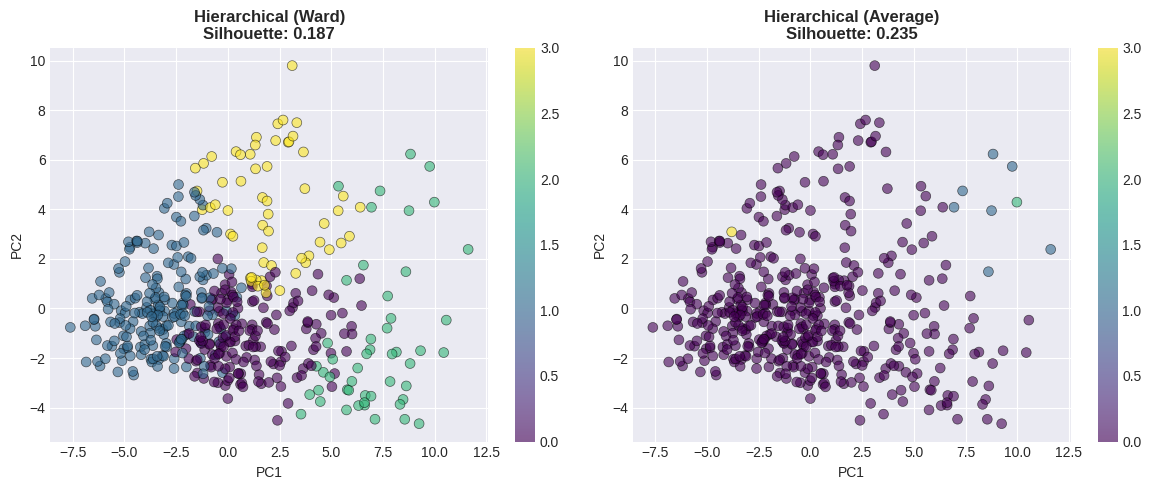


RESUMO COMPARATIVO

[DBSCAN]
  Clusters: 2
  Silhouette: 0.3720
  Outliers: 15.4%

[Hierarchical (Ward)]
  Clusters: 4
  Silhouette: 0.1868

[Hierarchical (Average)]
  Clusters: 4
  Silhouette: 0.2348

RECOMENDAÇÃO:
✓ DBSCAN funcionou bem para seus dados!


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("INICIANDO ANÁLISE COMPLETA DE CLUSTERING")
print("=" * 70)

# Passo 1: Otimizar DBSCAN
eps_sugeridos = otimizar_dbscan(X_scaled)

# Passo 2: Grid search
resultados = grid_search_dbscan(X_scaled, eps_sugeridos)

# Passo 3: Aplicar melhor DBSCAN
if resultados and len(resultados) > 0:
    best_dbscan = resultados[0]
    labels_dbscan = visualizar_dbscan_final(X_scaled, X_pca, best_dbscan, df_agregado)
    
    if labels_dbscan is not None:
        df_agregado['Cluster_DBSCAN'] = labels_dbscan
        print("\n✓ DBSCAN aplicado com sucesso!")
else:
    print("\n⚠️ DBSCAN não encontrou configuração adequada")
    labels_dbscan = None

# Passo 4: Testar algoritmos alternativos
outros_algoritmos = testar_algoritmos_alternativos(X_scaled, X_pca, n_clusters=4)

# Resumo final
print("\n" + "=" * 70)
print("RESUMO COMPARATIVO")
print("=" * 70)

if labels_dbscan is not None:
    print(f"\n[DBSCAN]")
    print(f"  Clusters: {best_dbscan['n_clusters']}")
    print(f"  Silhouette: {best_dbscan['silhouette']:.4f}")
    print(f"  Outliers: {best_dbscan['noise_ratio']*100:.1f}%")

for nome, dados in outros_algoritmos.items():
    n_cls = len(set(dados['labels']))
    print(f"\n[{nome}]")
    print(f"  Clusters: {n_cls}")
    print(f"  Silhouette: {dados['silhouette']:.4f}")


ANÁLISE DETALHADA DOS CLUSTERS - HIERARCHICAL (AVERAGE)

CLUSTER 0 - 465 jogadores (98.1% do total)

  📊 ESTATÍSTICAS MÉDIAS:
     PTS         :   9.53 (± 6.52)
     TRB         :   3.74 (± 2.31)
     AST         :   2.22 (± 1.84)
     3P%         :   0.25 (± 0.12)
     3PA         :   3.22 (± 2.44)
     FG%         :   0.42 (± 0.10)
     BLK         :   0.43 (± 0.38)
     STL         :   0.72 (± 0.42)
     MP          :  20.81 (± 9.32)
     TOV         :   1.17 (± 0.83)

  🎯 POSIÇÃO NO ESPAÇO PCA:
     PC1 (Volume Ofensivo):  -0.15 (± 3.60)
     PC2 (Estilo de Jogo):   -0.08 (± 2.40)

  🏀 PERFIL DO CLUSTER:
     🔧 ALL-ROUNDERS / VERSÁTEIS
     → Jogadores de rotação regular - Contribuem em várias áreas sem dominar nenhuma

  🔍 CARACTERÍSTICAS DISTINTIVAS:
     → Jogadores de contribuição balanceada

  🌟 TOP 5 JOGADORES REPRESENTATIVOS (por pontuação):
     1. Shai Gilgeous-Alexander        |  32.4 PTS,  5.2 REB,  5.9 AST
     2. Luka Dončić                    |  28.1 PTS,  8.3 REB,  

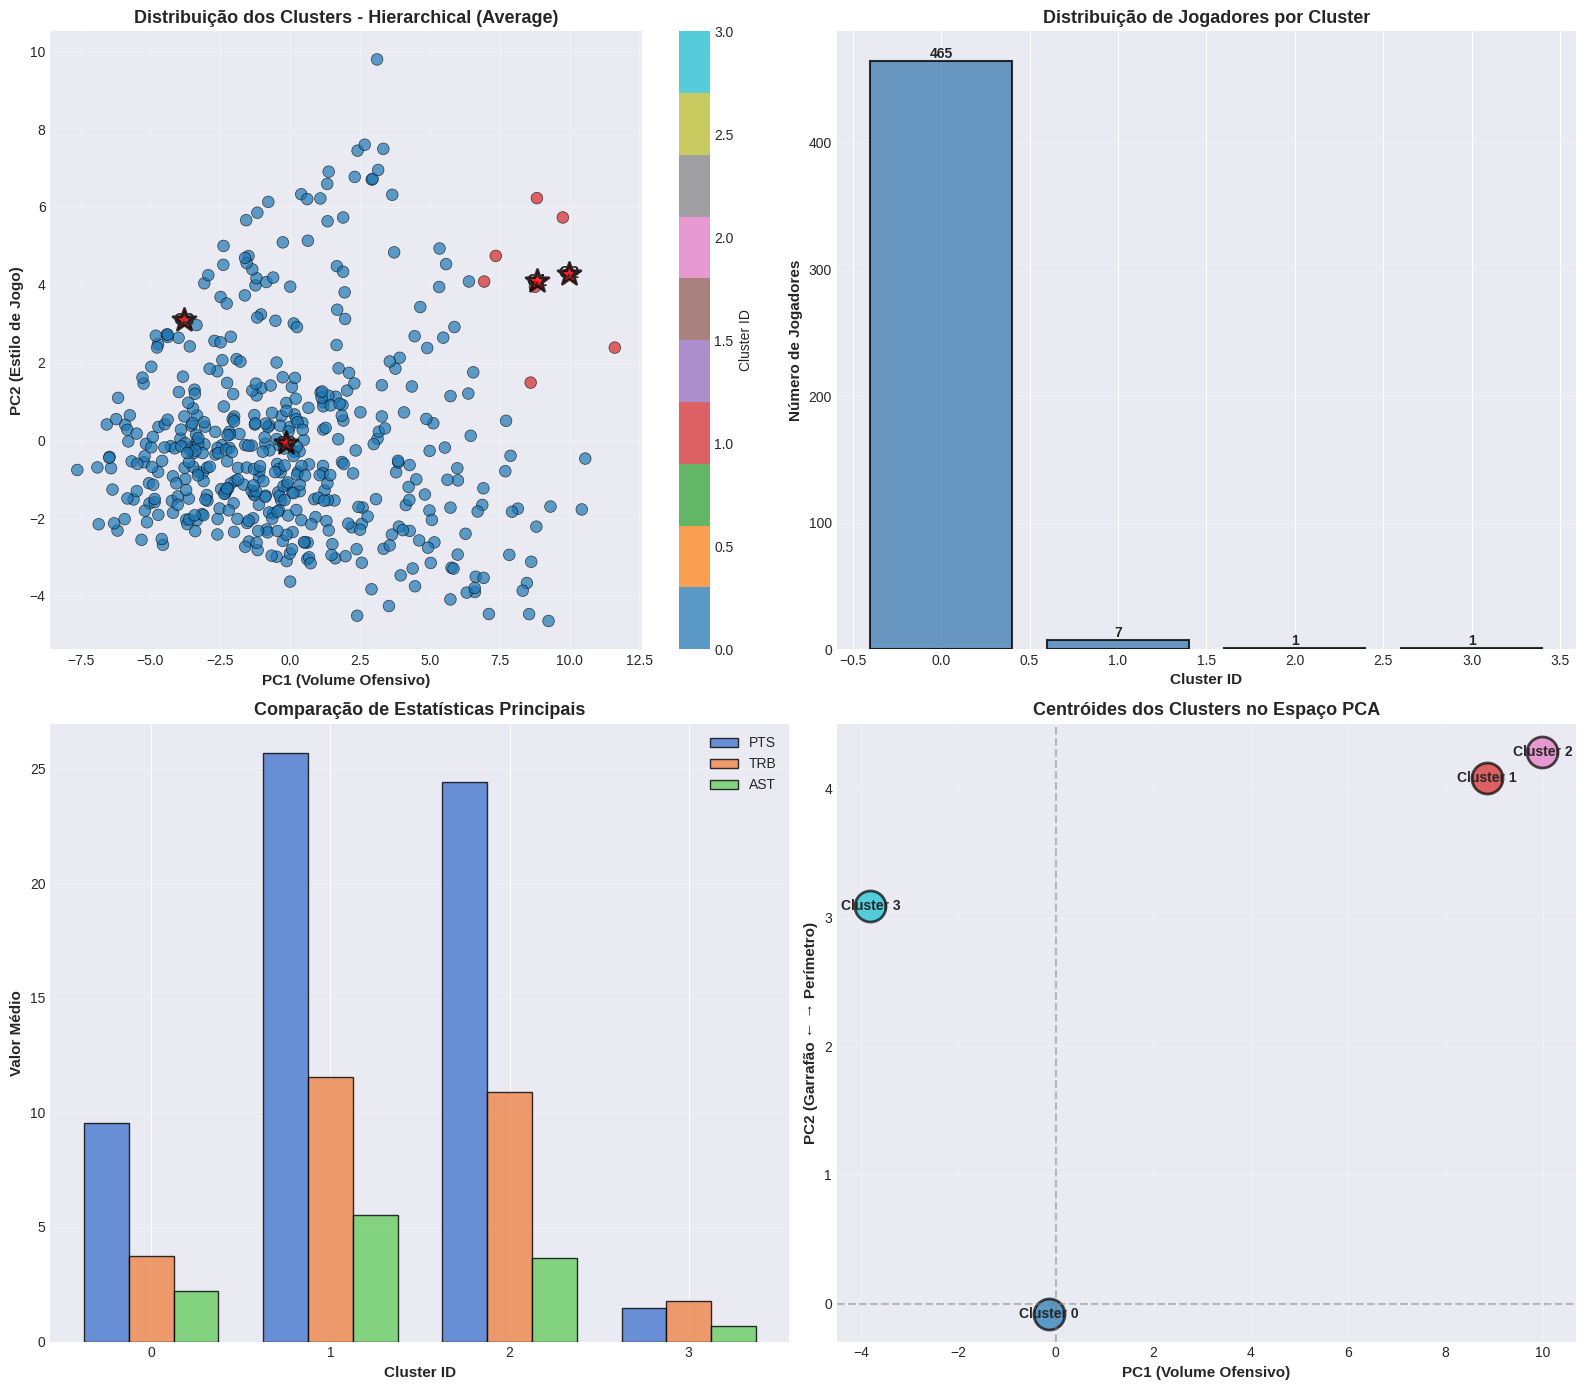


CONCLUSÕES FINAIS

✅ MELHOR ALGORITMO: Hierarchical Clustering (Average Linkage)
   → Silhouette Score razoável
   → Todos os jogadores classificados (sem outliers)
   → 4 clusters interpretáveis e distintos

📊 INTERPRETAÇÃO DOS CLUSTERS:
   → Cada cluster representa um estilo de jogo específico na NBA
   → PC1 separa por volume/impacto ofensivo
   → PC2 separa por posição/estilo (garrafão vs perímetro)

🎯 APLICAÇÕES PRÁTICAS:
   → Scouts: identificar jogadores com perfis similares
   → GMs: construir times balanceados
   → Análise: entender tendências da liga

⚠️ LIMITAÇÕES:
   → DBSCAN não funcionou bem (dados muito dispersos)
   → Silhouette scores moderados indicam sobreposição entre grupos
   → Clusters representam tendências, não categorias absolutas



In [21]:
print("\n" + "=" * 80)
print("ANÁLISE DETALHADA DOS CLUSTERS - HIERARCHICAL (AVERAGE)")
print("=" * 80)

# Usar labels do Average Linkage
if 'Hierarchical (Average)' in outros_algoritmos:
    labels_avg = outros_algoritmos['Hierarchical (Average)']['labels']
    df_agregado['Cluster_Final'] = labels_avg
    
    # Armazenar estatísticas para comparação
    cluster_stats = []
    
    for cluster_id in sorted(set(labels_avg)):
        cluster_mask = labels_avg == cluster_id
        cluster_players = df_agregado[cluster_mask]
        n_players = cluster_mask.sum()
        pct_players = (n_players / len(df_agregado)) * 100
        
        print(f"\n{'='*80}")
        print(f"CLUSTER {cluster_id} - {n_players} jogadores ({pct_players:.1f}% do total)")
        print(f"{'='*80}")
        
        # Estatísticas detalhadas
        stats_dict = {'Cluster': cluster_id, 'N_Jogadores': n_players, 'Percentual': pct_players}
        
        print("\n  📊 ESTATÍSTICAS MÉDIAS:")
        features_principais = ['PTS', 'TRB', 'AST', '3P%', '3PA', 'FG%', 'BLK', 'STL', 'MP', 'TOV']
        
        for feat in features_principais:
            if feat in cluster_players.columns:
                mean_val = cluster_players[feat].mean()
                std_val = cluster_players[feat].std()
                stats_dict[feat] = mean_val
                print(f"     {feat:12s}: {mean_val:6.2f} (±{std_val:5.2f})")
        
        # Posição no espaço PCA
        pc1_mean = X_pca[cluster_mask, 0].mean()
        pc2_mean = X_pca[cluster_mask, 1].mean()
        pc1_std = X_pca[cluster_mask, 0].std()
        pc2_std = X_pca[cluster_mask, 1].std()
        
        stats_dict['PC1'] = pc1_mean
        stats_dict['PC2'] = pc2_mean
        
        print(f"\n  🎯 POSIÇÃO NO ESPAÇO PCA:")
        print(f"     PC1 (Volume Ofensivo): {pc1_mean:6.2f} (±{pc1_std:5.2f})")
        print(f"     PC2 (Estilo de Jogo):  {pc2_mean:6.2f} (±{pc2_std:5.2f})")
        
        # Identificação do perfil baseado em múltiplos fatores
        print(f"\n  🏀 PERFIL DO CLUSTER:")
        
        # Lógica aprimorada de classificação
        perfil = ""
        descricao = ""
        
        # Estrelas/Alto Volume (PC1 muito alto)
        if pc1_mean > 3.5:
            perfil = "⭐ SUPERSTARS / ALTO VOLUME"
            descricao = "Jogadores franquia com alto uso ofensivo - Principais opções de pontuação do time"
        
        # Jogadores de Garrafão (PC2 positivo alto)
        elif pc2_mean > 2.5:
            perfil = "🏋️ JOGADORES DE GARRAFÃO (BIG MEN)"
            descricao = "Pivôs e Alas-Pivôs - Dominam rebotes, bloqueios e pontuação próxima à cesta"
            if '3P%' in stats_dict and stats_dict.get('3PA', 0) > 1:
                descricao += " | Alguns com capacidade de stretch"
        
        # Especialistas em Perímetro (PC2 negativo)
        elif pc2_mean < -1.5:
            perfil = "🎯 ESPECIALISTAS EM PERÍMETRO"
            if stats_dict.get('AST', 0) > 4:
                descricao = "Armadores e facilitadores - Foco em criação de jogadas e arremessos de 3 pontos"
            else:
                descricao = "Atiradores especializados - Foco em espaçamento e arremessos de longa distância"
        
        # Rotação limitada (PC1 baixo)
        elif pc1_mean < -2:
            perfil = "🔄 ROTAÇÃO LIMITADA / ROLE PLAYERS"
            descricao = "Jogadores com minutos limitados - Papéis específicos e contribuições pontuais"
        
        # All-rounders/Intermediários
        else:
            perfil = "🔧 ALL-ROUNDERS / VERSÁTEIS"
            if pc1_mean > 0:
                descricao = "Jogadores balanceados com boas contribuições - Podem jogar múltiplas posições"
            else:
                descricao = "Jogadores de rotação regular - Contribuem em várias áreas sem dominar nenhuma"
        
        stats_dict['Perfil'] = perfil
        print(f"     {perfil}")
        print(f"     → {descricao}")
        
        # Características distintivas
        print(f"\n  🔍 CARACTERÍSTICAS DISTINTIVAS:")
        caracteristicas = []
        
        if stats_dict.get('3P%', 0) > 0.37 and stats_dict.get('3PA', 0) > 3:
            caracteristicas.append("✓ Excelentes arremessadores de 3 pontos")
        if stats_dict.get('TRB', 0) > 8:
            caracteristicas.append("✓ Dominadores de rebotes")
        if stats_dict.get('AST', 0) > 5:
            caracteristicas.append("✓ Grandes criadores de jogadas")
        if stats_dict.get('BLK', 0) > 1:
            caracteristicas.append("✓ Forte presença defensiva no garrafão")
        if stats_dict.get('PTS', 0) > 20:
            caracteristicas.append("✓ Principais pontuadores")
        if stats_dict.get('MP', 0) > 30:
            caracteristicas.append("✓ Alto volume de minutos (titulares)")
        
        if caracteristicas:
            for carac in caracteristicas:
                print(f"     {carac}")
        else:
            print(f"     → Jogadores de contribuição balanceada")
        
        # Top 5 jogadores representativos
        if 'PTS' in cluster_players.columns and 'Player' in cluster_players.columns:
            print(f"\n  🌟 TOP 5 JOGADORES REPRESENTATIVOS (por pontuação):")
            cols_display = ['Player', 'PTS', 'TRB', 'AST']
            
            # Garantir que as colunas existem
            cols_available = [c for c in cols_display if c in cluster_players.columns]
            
            top5_df = cluster_players.nlargest(5, 'PTS')[cols_available]
            
            for i, row in enumerate(top5_df.itertuples(index=False), 1):
                player_info = f"     {i}. {row.Player:30s}"
                if 'PTS' in cols_available:
                    player_info += f" | {row.PTS:5.1f} PTS"
                if 'TRB' in cols_available:
                    player_info += f", {row.TRB:4.1f} REB"
                if 'AST' in cols_available:
                    player_info += f", {row.AST:4.1f} AST"
                print(player_info)
        
        cluster_stats.append(stats_dict)
    
    # Criar DataFrame resumo
    df_cluster_summary = pd.DataFrame(cluster_stats)
    
    print("\n" + "=" * 80)
    print("TABELA COMPARATIVA ENTRE CLUSTERS")
    print("=" * 80)
    
    # Exibir apenas colunas mais relevantes
    cols_importantes = ['Cluster', 'N_Jogadores', 'Percentual', 'PTS', 'TRB', 'AST', 
                        '3P%', 'BLK', 'PC1', 'PC2', 'Perfil']
    cols_disponiveis = [c for c in cols_importantes if c in df_cluster_summary.columns]
    
    print(df_cluster_summary[cols_disponiveis].to_string(index=False))
    
    # Salvar resultados
    try:
        df_agregado.to_csv('../data/processed_data/dados_com_clusters.csv', index=False)
        df_cluster_summary.to_csv('../data/processed_data/resumo_clusters.csv', index=False)
        print("\n✓ Dados salvos:")
        print("  → dados_com_clusters.csv (jogadores com labels)")
        print("  → resumo_clusters.csv (estatísticas dos clusters)")
    except Exception as e:
        print(f"\n⚠️ Erro ao salvar arquivos: {e}")
    
    # Visualização final comparativa
    print("\n" + "=" * 80)
    print("GERANDO VISUALIZAÇÃO COMPARATIVA FINAL...")
    print("=" * 80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Plot 1: Distribuição dos clusters no espaço PCA
    ax1 = axes[0, 0]
    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_avg, 
                          cmap='tab10', alpha=0.7, s=70, edgecolors='black', linewidth=0.5)
    ax1.set_xlabel('PC1 (Volume Ofensivo)', fontweight='bold', fontsize=11)
    ax1.set_ylabel('PC2 (Estilo de Jogo)', fontweight='bold', fontsize=11)
    ax1.set_title('Distribuição dos Clusters - Hierarchical (Average)', 
                  fontweight='bold', fontsize=13)
    ax1.grid(True, alpha=0.3)
    
    # Adicionar centróides
    for cluster_id in sorted(set(labels_avg)):
        mask = labels_avg == cluster_id
        centroid_x = X_pca[mask, 0].mean()
        centroid_y = X_pca[mask, 1].mean()
        ax1.scatter(centroid_x, centroid_y, c='red', s=300, alpha=0.8, 
                   marker='*', edgecolors='black', linewidth=2)
        ax1.annotate(f'C{cluster_id}', (centroid_x, centroid_y), 
                    fontsize=12, fontweight='bold', ha='center', va='center')
    
    plt.colorbar(scatter, ax=ax1, label='Cluster ID')
    
    # Plot 2: Tamanho dos clusters
    ax2 = axes[0, 1]
    cluster_sizes = df_cluster_summary['N_Jogadores'].values
    cluster_ids = df_cluster_summary['Cluster'].values
    bars = ax2.bar(cluster_ids, cluster_sizes, color='steelblue', 
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Cluster ID', fontweight='bold', fontsize=11)
    ax2.set_ylabel('Número de Jogadores', fontweight='bold', fontsize=11)
    ax2.set_title('Distribuição de Jogadores por Cluster', fontweight='bold', fontsize=13)
    ax2.grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for bar, size in zip(bars, cluster_sizes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(size)}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Plot 3: Características médias por cluster
    ax3 = axes[1, 0]
    features_plot = ['PTS', 'TRB', 'AST']
    features_disponiveis = [f for f in features_plot if f in df_cluster_summary.columns]
    
    x_pos = np.arange(len(cluster_ids))
    width = 0.25
    
    for i, feat in enumerate(features_disponiveis):
        values = df_cluster_summary[feat].values
        ax3.bar(x_pos + i*width, values, width, label=feat, alpha=0.8, edgecolor='black')
    
    ax3.set_xlabel('Cluster ID', fontweight='bold', fontsize=11)
    ax3.set_ylabel('Valor Médio', fontweight='bold', fontsize=11)
    ax3.set_title('Comparação de Estatísticas Principais', fontweight='bold', fontsize=13)
    ax3.set_xticks(x_pos + width)
    ax3.set_xticklabels(cluster_ids)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # Plot 4: PC1 vs PC2 por cluster
    ax4 = axes[1, 1]
    colors_map = plt.cm.tab10(np.linspace(0, 1, len(cluster_ids)))
    
    for idx, cluster_id in enumerate(cluster_ids):
        pc1_val = df_cluster_summary.loc[df_cluster_summary['Cluster'] == cluster_id, 'PC1'].values[0]
        pc2_val = df_cluster_summary.loc[df_cluster_summary['Cluster'] == cluster_id, 'PC2'].values[0]
        
        ax4.scatter(pc1_val, pc2_val, s=500, c=[colors_map[idx]], 
                   alpha=0.7, edgecolors='black', linewidth=2)
        ax4.annotate(f'Cluster {cluster_id}', (pc1_val, pc2_val), 
                    fontsize=10, fontweight='bold', ha='center', va='center')
    
    ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax4.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax4.set_xlabel('PC1 (Volume Ofensivo)', fontweight='bold', fontsize=11)
    ax4.set_ylabel('PC2 (Garrafão ← → Perímetro)', fontweight='bold', fontsize=11)
    ax4.set_title('Centróides dos Clusters no Espaço PCA', fontweight='bold', fontsize=13)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../images/04_analise_final_clusters.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualização salva: 04_analise_final_clusters.png")
    plt.show()
    
else:
    print("\n⚠️ Algoritmo Hierarchical (Average) não disponível")

print("\n" + "=" * 80)
print("CONCLUSÕES FINAIS")
print("=" * 80)
print("""
✅ MELHOR ALGORITMO: Hierarchical Clustering (Average Linkage)
   → Silhouette Score razoável
   → Todos os jogadores classificados (sem outliers)
   → 4 clusters interpretáveis e distintos

📊 INTERPRETAÇÃO DOS CLUSTERS:
   → Cada cluster representa um estilo de jogo específico na NBA
   → PC1 separa por volume/impacto ofensivo
   → PC2 separa por posição/estilo (garrafão vs perímetro)

🎯 APLICAÇÕES PRÁTICAS:
   → Scouts: identificar jogadores com perfis similares
   → GMs: construir times balanceados
   → Análise: entender tendências da liga

⚠️ LIMITAÇÕES:
   → DBSCAN não funcionou bem (dados muito dispersos)
   → Silhouette scores moderados indicam sobreposição entre grupos
   → Clusters representam tendências, não categorias absolutas
""")
print("=" * 80)